# Introduction
This notebook presents the experiment we have performed to check amount of wrong predictions according to quantity of plume.

## Prepare environment

In [1]:
import os
import torch
import pandas as pd

from torch.utils.data import Dataset
from typing import Type

from dataset.dataset_info import DatasetInfo, MMClassifierDatasetInfo
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from dataset.dataset_type import DatasetType
from files_handler.model_files_handler import ModelFilesHandler

os.chdir(r"..\..")
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare class for dataloader.

In [2]:
class STARCOPDataset(Dataset):
    def __init__(
            self,
            data_path: str,
            data_type: DatasetType,
            image_info_class: Type[DatasetInfo],
            crop_size: int = 1,
    ):
        self.images_path = os.path.join(data_path, data_type.get_folder_name(), data_type.get_folder_name())
        self.image_info = image_info_class
        self.csv = pd.read_csv(os.path.join(data_path, data_type.value + ".csv"))
        self.crop_size = crop_size

    def __len__(self):
        return len(self.csv) * (self.crop_size * self.crop_size)

    def __getitem__(self, index):
        return self._get_raw_item(index)

    def _get_raw_item(self, index):
        file_index = index // (self.crop_size * self.crop_size)
        images_directory_path = os.path.join(self.images_path, self.csv["id"][file_index])

        return self.csv["qplume"][file_index], self.image_info.load_tensor(
            images_directory_path,
            grid_id=index % (self.crop_size * self.crop_size),
            crop_size=self.crop_size
        )

    def _get_normalized_item(self, index):
        images = self._get_raw_item(index)
        normalized_image = self.normalize_image(images[0])
        normalized_mag1c = self.normalize_mag1c(images[2])

        results = normalized_image, images[1], normalized_mag1c, images[3], images[4], images[5], images[6]
        return results

## Create dataloader

In [3]:
dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=MMClassifierDatasetInfo,
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
model_handler = ModelFilesHandler()

## Compute wrongly predicted sizes for CNN

In [4]:
cnn_wrong_plume_sizes = []
all_plume_sizes = []
file_name = r"best_models\CNN\model_cnn_2024_12_14_13_20_07.pickle"
cnn_model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

cnn_model.eval()
cnn_model.to(device)


for id, image in enumerate(dataloader):
    plume_size, (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = cnn_model(input_image)
    predictions = torch.argmax(outputs, dim=1)

    all_plume_sizes.append(plume_size.item())
    if (predictions != labels).all():
        cnn_wrong_plume_sizes.append(plume_size.item())


cnn_model.to("cpu")

MethaNetClassifier(
  (pre_conv): Sequential(
    (0): Conv2d(9, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(4, 2, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(12, 16, kernel_size=(4, 4), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=59536, out_features=64, bias=True)
    (2): ReLU()
    (3):

## Compute wrongly predicted sizes for DETR

In [5]:
detr_wrong_plume_sizes = []
file_name = r"best_models\DETR\model_detr_2024_12_15_11_35_17.pickle"
detr_model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

detr_model.eval()
detr_model.to(device)


for id, image in enumerate(dataloader):
    plume_size, (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = detr_model(input_image)
    predictions = torch.argmax(outputs, dim=1)

    if (predictions != labels).all():
        detr_wrong_plume_sizes.append(plume_size.item())


detr_model.to("cpu")

D:\Projects\studia\polsl_ssi_1\MethaneDetection\Thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CustomDetrForClassification(
  (detr): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (

## Compute wrongly predicted sizes for Methane Mapper

In [6]:
mm_wrong_plume_sizes = []
file_name = r"best_models\MethaneMapper\model_transformer_classifier_2024_12_02_00_37_54.pickle"
mm_model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

mm_model.eval()
mm_model.to(device)


for id, image in enumerate(dataloader):
    plume_size, (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    filtered_image = filtered_image.to(device)
    labels = label.long().to(device)

    outputs = mm_model(input_image, filtered_image)
    predictions = torch.argmax(outputs, dim=1)


    if (predictions != labels).all():
        mm_wrong_plume_sizes.append(plume_size.item())


mm_model.to("cpu")

TransformerModel(
  (backbone): Backbone(
    (rgb_backbone): CustomResnet(
      (resnet): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

## Compute wrongly predicted sizes for ViT

In [7]:
vit_wrong_plume_sizes = []
file_name = r"best_models\VIT\model_vit_2024_12_15_11_50_56.pickle"
vit_model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

vit_model.eval()
vit_model.to(device)


for id, image in enumerate(dataloader):
    plume_size, (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = vit_model(input_image)
    predictions = torch.argmax(outputs, dim=1)
    
    if (predictions != labels).all():
        vit_wrong_plume_sizes.append(plume_size.item())

vit_model.to("cpu")

CustomViT(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(9, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNo

## Results presentation

Distribution of All Plume Sizes


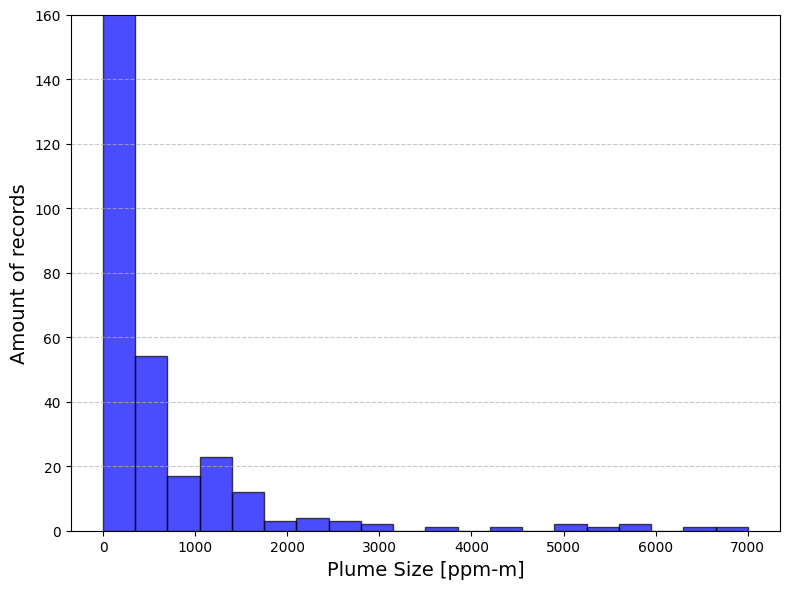

Distribution of Wrongly Predicted Plume Sizes (CNN)


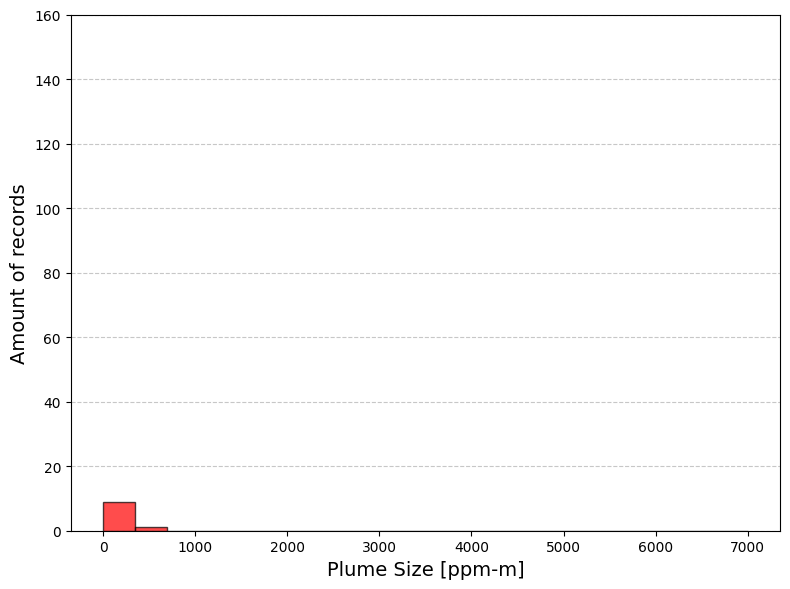

Distribution of Wrongly Predicted Plume Sizes (DETR)


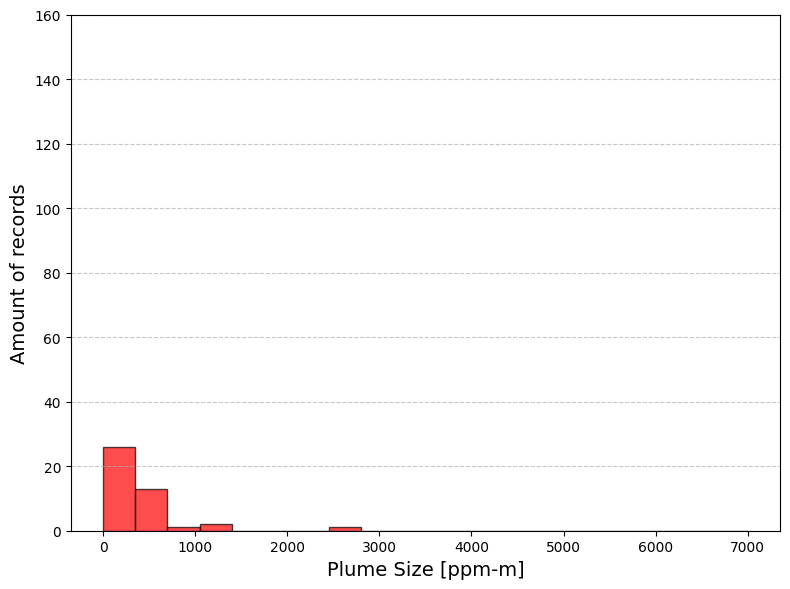

Distribution of Wrongly Predicted Sizes (MM)


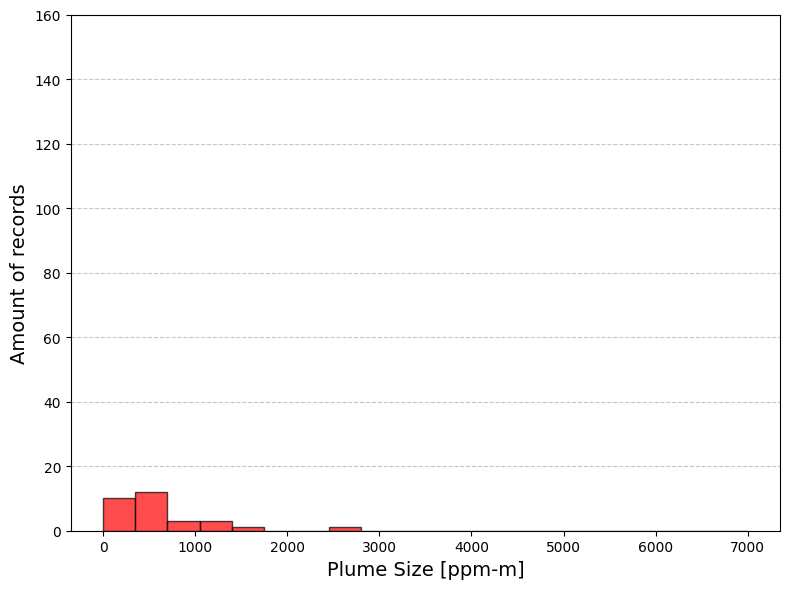

Distribution of Wrongly Predicted Plume Sizes (VIT)


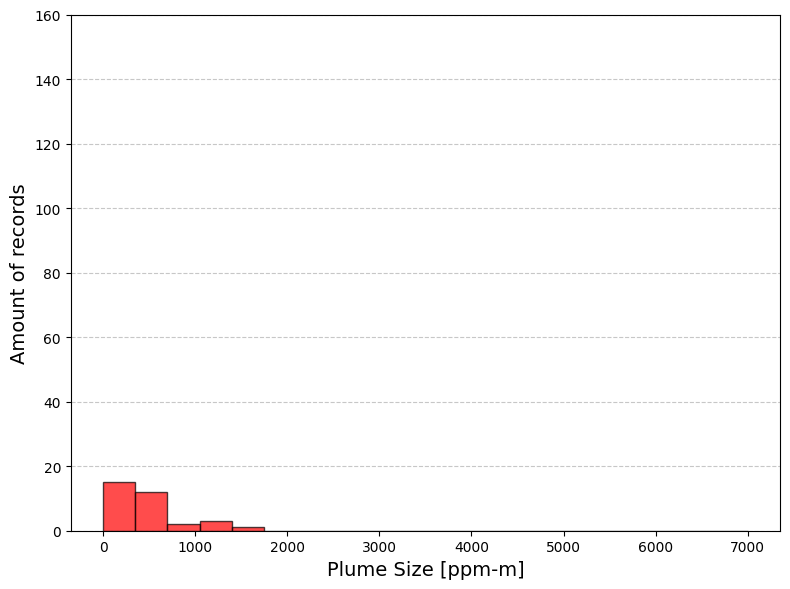

In [8]:
def plot_histogram(data, bins, range, color, edgecolor, alpha, title, xlabel, ylabel, ylim, filename):
    print(title)
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=bins, range=range, color=color, edgecolor=edgecolor, alpha=alpha)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.ylim(ylim)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

x_min = 0
x_max = 7000
y_min = 0
y_max = 160
bins = 20
range_vals = (x_min, x_max)
color = 'red'
edgecolor = 'black'
alpha = 0.7
ylim = (y_min, y_max)

plot_histogram(
    all_plume_sizes, bins, range_vals, 'blue', edgecolor, alpha,
    'Distribution of All Plume Sizes', 'Plume Size [ppm-m]', 'Amount of records', ylim,
    'all_plume_size.png'
)

plot_histogram(
    cnn_wrong_plume_sizes, bins, range_vals, color, edgecolor, alpha,
    'Distribution of Wrongly Predicted Plume Sizes (CNN)', 'Plume Size [ppm-m]', 'Amount of records', ylim,
    'cnn_plume_size.png'
)

plot_histogram(
    detr_wrong_plume_sizes, bins, range_vals, color, edgecolor, alpha,
    'Distribution of Wrongly Predicted Plume Sizes (DETR)', 'Plume Size [ppm-m]', 'Amount of records', ylim,
    'detr_plume_size.png'
)

plot_histogram(
    mm_wrong_plume_sizes, bins, range_vals, color, edgecolor, alpha,
    'Distribution of Wrongly Predicted Sizes (MM)', 'Plume Size [ppm-m]', 'Amount of records', ylim,
    'mm_plume_size.png'
)

plot_histogram(
    vit_wrong_plume_sizes, bins, range_vals, color, edgecolor, alpha,
    'Distribution of Wrongly Predicted Plume Sizes (VIT)', 'Plume Size [ppm-m]', 'Amount of records', ylim,
    'vit_plume_size.png'
)

## Restore environment

In [9]:
os.chdir(r".\notebooks\experiments")